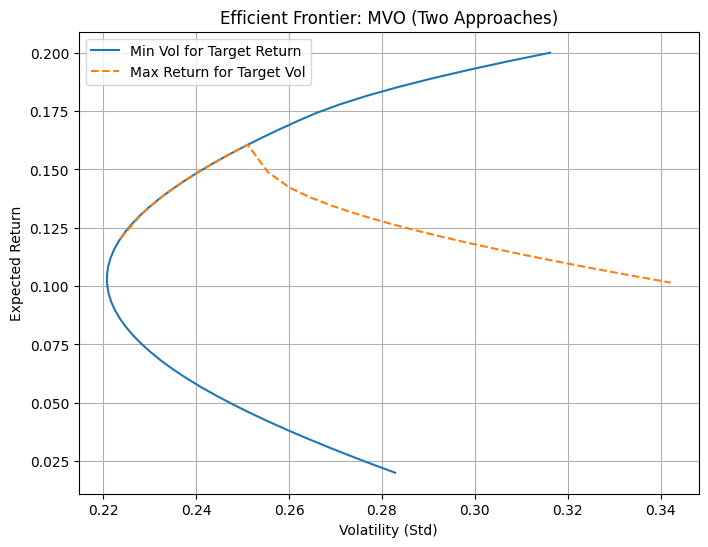

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# --- Data ---
names = ['A', 'B', 'C']
mu = np.array([0.20, 0.10, 0.02])
Sigma = np.array([
    [0.10, 0.02, 0.01],
    [0.02, 0.12, 0.06],
    [0.01, 0.06, 0.08]
])
n = len(mu)

# --- MVO: Min Vol for Target Return ---
def min_vol_for_target_return(target, mu, Sigma):
    cons = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: w @ mu - target}
    ]
    bounds = [(0, 1) for _ in range(len(mu))]
    res = minimize(lambda w: w @ Sigma @ w, x0=np.ones(n)/n, constraints=cons, bounds=bounds)
    return res

# --- MVO: Max Return for Target Vol ---
def max_ret_for_target_vol(target_vol, mu, Sigma, tol=1e-4, n_start=5):
    best_res = None
    for _ in range(n_start):
        x0 = np.random.dirichlet(np.ones(len(mu)))
        cons = [
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'ineq', 'fun': lambda w: np.sqrt(w @ Sigma @ w) - (target_vol - tol)},
            {'type': 'ineq', 'fun': lambda w: (target_vol + tol) - np.sqrt(w @ Sigma @ w)},
        ]
        bounds = [(0, 1) for _ in range(len(mu))]
        res = minimize(lambda w: -w @ mu, x0=x0, constraints=cons, bounds=bounds)
        if res.success and (best_res is None or res.fun < best_res.fun):
            best_res = res
    return best_res


# --- Efficient Frontier 1: Target Return, Min Vol ---
target_returns = np.linspace(min(mu), max(mu), 50)
vols1, rets1 = [], []
for r in target_returns:
    res = min_vol_for_target_return(r, mu, Sigma)
    if res.success:
        vols1.append(np.sqrt(res.x @ Sigma @ res.x))
        rets1.append(res.x @ mu)
    else:
        vols1.append(np.nan)
        rets1.append(np.nan)

# --- Efficient Frontier 2: Target Vol, Max Return ---
target_vols = np.linspace(np.sqrt(0.05), np.sqrt(0.20), 50)
vols2, rets2 = [], []
for v in target_vols:
    res = max_ret_for_target_vol(v, mu, Sigma)
    if res.success:
        vols2.append(np.sqrt(res.x @ Sigma @ res.x))
        rets2.append(res.x @ mu)
    else:
        vols2.append(np.nan)
        rets2.append(np.nan)

# --- Plot ---
plt.figure(figsize=(8,6))
plt.plot(vols1, rets1, label='Min Vol for Target Return')
plt.plot(vols2, rets2, label='Max Return for Target Vol', linestyle='--')
plt.xlabel('Volatility (Std)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier: MVO (Two Approaches)')
plt.legend()
plt.grid(True)
plt.show()
